### Importação de Libs

In [1]:
import pandas as pd
import numpy as np
from category_encoders import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

In [2]:
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
from mlxtend.classifier import EnsembleVoteClassifier

In [3]:
from mlxtend.evaluate import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import plotly.express as px

In [4]:
from fastai.tabular.all import *
import warnings

warnings.filterwarnings('ignore')

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
ID = test['PassengerId']
IMPUTER = KNNImputer(n_neighbors=10, weights='distance')
SCALER = MinMaxScaler()

In [6]:
SEED = 42

### Feature Engineering

#### Making Functions and Most Important variables/constants

In [7]:
def search_title(x):
    y = list(x)
    if y.index(','):
        y = y[y.index(',') + 2:y.index(" ", y.index(',') + 2)]
        return "".join(y)

In [8]:
def to_miss(x):
    arr = ['Mlle.', 'Mme.', 'Lady.', 'Ms.', 'Dona.']
    if x in arr:
        x = 'Miss.'
    return x

In [9]:
def to_mr(x):
    arr = ['Dr.', 'Rev.', 'Col.', 'Major.', 'Capt.', 'the.', 'Jonkheer.', 'Sir.', 'Don.', 'the' , 'Master.']
    if x in arr:
        x = 'Mr.'
    return x

In [10]:
def is_married(x):
    if x == 'Mrs.':
        return 1
    return 0

In [11]:
def is_alone(x):
    if x == 0:
        return 1
    return 0

In [12]:
def below_age(x):
    if x < 18:
        return 1
    return 0

##### Imputing Age

In [13]:
train[['Age']] = IMPUTER.fit_transform(train[['Age']])

In [14]:
train['Title'] = train['Name'].apply(search_title) #make a column of titles
train['Title'] = train['Title'].apply(to_miss) #separate titles that can go to Miss
train['Title'] = train['Title'].apply(to_mr) #separate titles that can go to Mr.

In [15]:
train['is_married'] = train['Title'].apply(is_married) #check if the person are married or not

In [16]:
train['below_age'] = train['Age'].apply(below_age) #check if the passanger is a child or not

In [17]:
train['family_size'] = train['SibSp'] + train['Parch'] #make a column about the family size on Titanic

In [18]:
train['is_alone'] = train['family_size'].apply(is_alone) #check if the passanger are alone

##### Dropping NaN and Unwanted Columns

In [19]:
train.drop(columns=['PassengerId', 'Cabin', 'Name'], inplace=True)

In [20]:
embarked_rows_to_drop = train[train[['Embarked']].isnull().any(axis=1)].index.values

In [21]:
train.drop(index=embarked_rows_to_drop, inplace=True)

### Feature Engineering

In [22]:
cont = ['Age', 'Fare', 'family_size']
cat  = ['Sex', 'Ticket', 'SibSp', 'Parch', 'Pclass', 'Embarked', 'Title', 'is_alone', 'is_married', 'below_age']
dep_var = 'Survived'

In [23]:
procs = [Categorify, FillMissing, Normalize]

In [24]:
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(train))

In [25]:
to = TabularPandas(train, procs=procs, cat_names=cat, cont_names=cont, 
                   y_names=dep_var, y_block=CategoryBlock(), splits=splits)

In [26]:
xs = to.train.xs
y = to.train.y

In [27]:
valid_xs = to.valid.xs
valid_y = to.valid.y

In [28]:
dls = TabularDataLoaders.from_df(train, procs=procs, cat_names=cat, cont_names=cont,
                                y_names=dep_var, y_block=CategoryBlock(), bs=64, valid_idx=splits[1], set_seed=SEED)

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.005248074419796467)

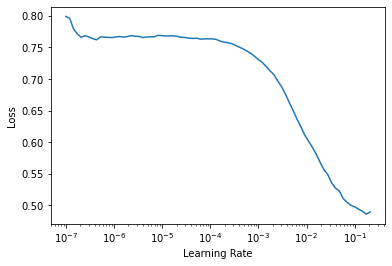

In [29]:
learn = tabular_learner(dls, layers=[100], metrics=accuracy)
learn.lr_find()

In [30]:
learn.fit_one_cycle(5, lr_max=4e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.579430,0.619838,0.768362,00:00
1,0.370188,0.437704,0.807910,00:00
2,0.255036,0.379330,0.870057,00:00
3,0.186109,0.619330,0.813559,00:00
4,0.140575,0.673212,0.830508,00:00


### Stacking Classifier

In [31]:
clfs = [RandomForestClassifier(), 
       LGBMClassifier(subsample_freq=1)]

labels = [str(x) for x in clfs]

labels = [x[:x.index("(")] for x in labels]

In [32]:
for clf, label in zip(clfs, labels):

    scores = cross_val_score(clf, xs, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

Accuracy: 0.84 (+/- 0.02) [RandomForestClassifier]
Accuracy: 0.82 (+/- 0.02) [LGBMClassifier]


#### Tuning

In [70]:
def search_hyperparams(params):

    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    n_estimators_lgbm = params[5]
    
    model = LGBMClassifier(random_state=SEED, 
                         subsample_freq=1, 
                         learning_rate=learning_rate,
                        num_leaves=num_leaves,
                        min_child_samples= min_child_samples,
                        subsample= subsample,
                        colsample_bytree = colsample_bytree,
                        n_estimators = n_estimators_lgbm)
    
    scores = cross_val_score(model, to.xs, to.y, cv=5, scoring='accuracy')
    
    return -scores.mean()

space = [
(1e-3, 1e-1, 'log-uniform'), #learning rate LGBM
(2, 128), #num_leaves LGBM
(1, 100), #min_child_samples LGBM
(0.05, 1.0), #subsample LGBM
(0.1, 1.0), #colsample_bytree LGBM
(100, 1000)] #n_estimators LGBM




#result = gp_minimize(search_hyperparams, space, verbose=1,n_calls = 30,random_state=SEED)

In [64]:
result.x

[0.022941144328643994, 59, 2, 0.9450916679006104, 0.6069593960609855, 447]

#### Validating

In [65]:
lgbm = LGBMClassifier(random_state=SEED, 
                         subsample_freq=1, 
                         learning_rate=0.022941144328643994,
                        num_leaves=59,
                        min_child_samples= 2,
                        subsample= 0.9450916679006104,
                        colsample_bytree = 0.6069593960609855,
                        n_estimators = 447)

In [66]:
lgbm.fit(xs, y)

LGBMClassifier(colsample_bytree=0.6069593960609855,
               learning_rate=0.022941144328643994, min_child_samples=2,
               n_estimators=447, num_leaves=59, random_state=42,
               subsample=0.9450916679006104, subsample_freq=1)

In [67]:
lgbm.score(valid_xs, valid_y)

0.8192090395480226

### Confusion Matrix

In [68]:
y_pred = lgbm.predict(valid_xs)

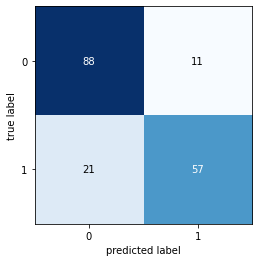

In [69]:
cm = confusion_matrix(valid_y, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=cm)

plt.show()


### Definitive Model of Random Forest

In [41]:
features = to.xs
label = to.y

In [43]:
lgbm.fit(features, label)

LGBMClassifier(colsample_bytree=0.6069593960609855,
               learning_rate=0.022941144328643994, min_child_samples=2,
               n_estimators=447, num_leaves=59, random_state=42,
               subsample=0.9450916679006104, subsample_freq=1)

##### Imputing Age and Fare

In [44]:
test[['Age']] = IMPUTER.fit_transform(test[['Age']])
test[['Fare']] = IMPUTER.fit_transform(test[['Fare']])

##### Feature Engineering on Df Set

In [45]:
test['Title'] = test['Name'].apply(search_title) #make a column of titles
test['Title'] = test['Title'].apply(to_miss) #separate titles that can go to Miss
test['Title'] = test['Title'].apply(to_mr) #separate titles that can go to Mr.
test['is_married'] = test['Title'].apply(is_married) #check if the person are married or not
test['below_age'] = test['Age'].apply(below_age) #check if the passanger is a child or not
test['family_size'] = test['SibSp'] + test['Parch'] #make a column about the family size on Titanic
test['is_alone'] = test['family_size'].apply(is_alone) #check if the passanger are alone

In [46]:
test.drop(columns=['PassengerId', 'Cabin', 'Name'], inplace=True)

In [47]:
test

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,is_married,below_age,family_size,is_alone
0,3,male,34.50000,0,0,330911,7.8292,Q,Mr.,0,0,0,1
1,3,female,47.00000,1,0,363272,7.0000,S,Mrs.,1,0,1,0
2,2,male,62.00000,0,0,240276,9.6875,Q,Mr.,0,0,0,1
3,3,male,27.00000,0,0,315154,8.6625,S,Mr.,0,0,0,1
4,3,female,22.00000,1,1,3101298,12.2875,S,Mrs.,1,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,male,30.27259,0,0,A.5. 3236,8.0500,S,Mr.,0,0,0,1
414,1,female,39.00000,0,0,PC 17758,108.9000,C,Miss.,0,0,0,1
415,3,male,38.50000,0,0,SOTON/O.Q. 3101262,7.2500,S,Mr.,0,0,0,1
416,3,male,30.27259,0,0,359309,8.0500,S,Mr.,0,0,0,1


In [48]:
to_test = TabularPandas(test, procs=procs, cat_names=cat, cont_names=cont)

In [49]:
to_test.xs

,Sex,Ticket,SibSp,Parch,Pclass,Embarked,Title,is_alone,is_married,below_age,Age,Fare,family_size
0,2,153,1,1,3,2,2,2,1,1,0.334994,-0.498407,-0.553443
1,1,222,2,1,3,3,3,1,2,1,1.325531,-0.513274,0.105643
2,2,74,1,1,2,2,2,2,1,1,2.514176,-0.465088,-0.553443
3,2,148,1,1,3,3,2,2,1,1,-0.259329,-0.483466,-0.553443
4,1,139,2,2,3,3,3,1,2,1,-0.655544,-0.418471,0.764728
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,2,268,1,1,3,3,2,2,1,1,0.000001,-0.494448,-0.553443
414,1,325,1,1,1,1,1,2,1,1,0.691587,1.313753,-0.553443
415,2,347,1,1,3,3,2,2,1,1,0.651966,-0.508792,-0.553443
416,2,221,1,1,3,3,2,2,1,1,0.000001,-0.494448,-0.553443


In [52]:
lgbm_res = lgbm.predict(to_test.xs)

In [53]:
dl = learn.dls.test_dl(to_test.xs)

In [54]:
preds = learn.get_preds(dl=dl)[0].numpy()

In [55]:
preds

array([[4.0872365e-02, 9.5912766e-01],
       [7.2623350e-02, 9.2737669e-01],
       [2.3967559e-03, 9.9760324e-01],
       [4.0447094e-02, 9.5955288e-01],
       [1.2643602e-01, 8.7356400e-01],
       [7.3010094e-02, 9.2698991e-01],
       [4.0618524e-02, 9.5938146e-01],
       [2.2461142e-03, 9.9775392e-01],
       [1.3001080e-01, 8.6998922e-01],
       [1.5275121e-01, 8.4724879e-01],
       [4.0633187e-02, 9.5936674e-01],
       [4.8244742e-04, 9.9951756e-01],
       [1.2104276e-03, 9.9878961e-01],
       [1.0722873e-03, 9.9892765e-01],
       [1.2710370e-03, 9.9872893e-01],
       [5.7953158e-03, 9.9420470e-01],
       [2.2854437e-03, 9.9771452e-01],
       [4.0115364e-02, 9.5988458e-01],
       [2.2229826e-02, 9.7777015e-01],
       [1.3594571e-01, 8.6405426e-01],
       [2.0809232e-04, 9.9979192e-01],
       [1.4283256e-01, 8.5716742e-01],
       [2.8841151e-03, 9.9711585e-01],
       [8.6098717e-04, 9.9913895e-01],
       [1.7622244e-03, 9.9823773e-01],
       [2.3162032e-02, 9.

In [56]:
learner_result = np.array([x.argmax() for x in preds])

In [57]:
learner_result

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [58]:
accuracy_score(y_test, learner_result)

NameError: name 'accuracy_score' is not defined

#### Dropping Unwanted Columns

#### OneHotEncoding, Scaling and Predicting

In [59]:
y_test = pd.read_csv('test_results.csv')

In [60]:
from sklearn.metrics import accuracy_score

In [61]:
y_test = y_test['Survived']

In [62]:
len(y_test)

418

In [63]:
accuracy_score(y_test, lgbm_res)

0.7799043062200957

#### Creating results.csv

In [ ]:
sub = pd.Series(y_pred, index=ID, name='Survived')
sub.to_csv("results.csv", header=True)